What we're going to cover

0. **Computer vision libraries in PyTorch:**	PyTorch has a bunch of built-in helpful computer vision libraries, let's check them out.
1. **Load data:**	To practice computer vision, we'll start with some images of different pieces of clothing from `FashionMNIST`.
2. **Prepare data:**	We've got some images, let's load them in with a **PyTorch** `DataLoader` so we can use them with our training loop.
3. **Model 0:** Building a baseline model	Here we'll create a multi-class classification model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
4. **Making predictions and evaluating model 0:**	Let's make some predictions with our baseline model and evaluate them.
5. **Setup device agnostic code for future models:**	It's best practice to write device-agnostic code, so let's set it up.
6. **Model 1:** Adding non-linearity	Experimenting is a large part of machine learning, let's try and improve upon our baseline model by adding non-linear layers.
7. **Model 2::** Convolutional Neural Network (CNN)	Time to get computer vision specific and introduce the powerful convolutional neural network architecture.
8.**Comparing our models:**	We've built three different models, let's compare them.
9. **Evaluating our best model:**	Let's make some predictions on random images and evaluate our best model.
10. **Making a confusion matrix:**	A confusion matrix is a great way to evaluate a classification model, let's see how we can make one.
11. **Saving and loading the best performing model:**	Since we might want to use our model for later, let's save it and make sure it loads back in correctly.

## 0. Computer vision libraries in PyTorch

* [`torchvision`] - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torch.transforms` - functions for manipulating your vision data(images) to be suitable to use with ML models
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates iterable over a dataset

In [ ]:
#Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt


#Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")
#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


## 1. Getting a dataset

The dataset that we will use is FashionMNIST from `torchvsion.datasets`

In [ ]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root = "data",  #where to download data to?
    train = True,  #Do we want the training dataset?
    download = True, #download data yes/no?
    transform = ToTensor(), #How do we want to transform the labels/targets
    target_transform = None #How do we want to transform the labels/targets?
)


test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:05<00:00, 880kB/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.06MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
image, train_label = train_data[0]
image = image.to(device)


In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[train_label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


##1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

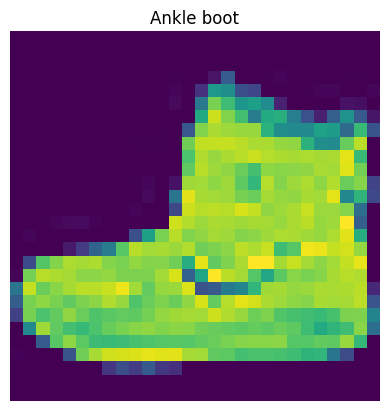

In [ ]:
image,label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

(-0.5, 27.5, 27.5, -0.5)

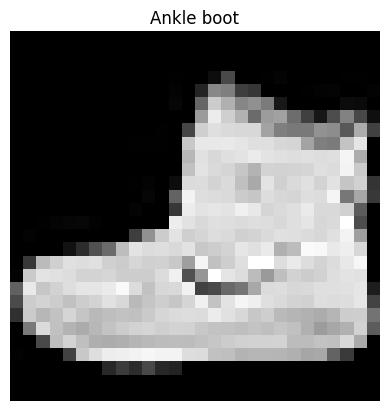

In [ ]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

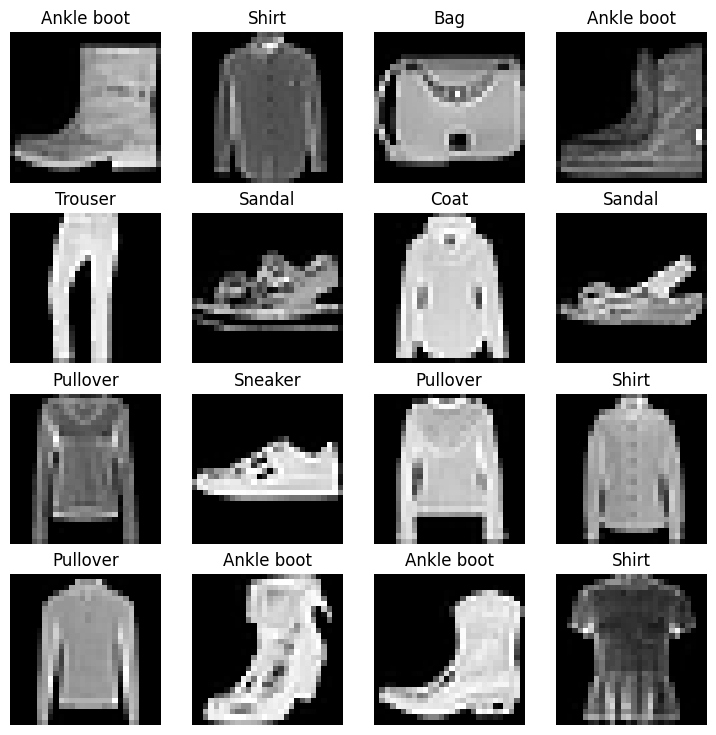

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, col = 4,4
for i in range(1, rows*col+1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, col, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non linearities?

## 2. Prepare the DataLoader

Right now our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into an iterable.

More specifically , we want to turn our data into batches (or mini-batches)

Why would we do this?

1. It is more computationally efficient, as in , your computing hardware may not be able to look (store in memory) at 6000 images in one hit, So, we break it down to 32 images at a time (batch size of 32).

2. It gives our neural network more chances to update its gradient descent.

In [ ]:
from torch.utils.data import DataLoader

#Setup batch size hyper parameters
BATCH_SIZE = 32

#Turn datasets into iterables(batches)

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)

test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)


In [ ]:
# Let's check out what we've created
print(f"Dataloader: {train_dataloader}\nLength of training dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images\nLength of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images")


Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f9b356cfdf0>
Length of training dataloader: 1875 batches of 32 images
Length of test dataloader: 313 batches of 32 images


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


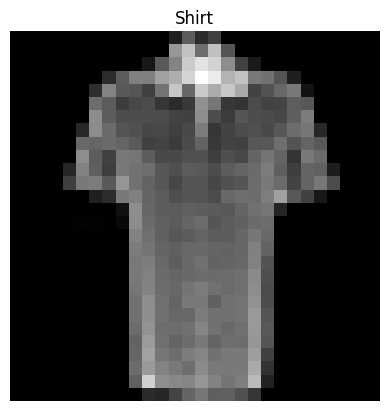

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a  series of machine learning modelling experiments, it's good practice to build a baseline model

A baseline model is a simple model you will try and improve upon with subsequent models/experiment

In other words: start simply and add complexity when necessary

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

# Check the shape
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

# Setup the model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape = 784,  #28*28
    hidden_units = 10 , #How many units in  the hidden layer
    output_shape = len(class_names) # One for every class
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1,1,28,28]).to(device)
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - we'll use `torch.optim.SGD()` (Stochastic Gradient Descent)
* Evaluation metric - we'll use `torchmetrics.Accuracy()`

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## 3.2 Creating a function to time our experiments

Machine Learning is very experimental.

Two of the main things you'll often want to track are:

1. Model's performance (loss and acuracy values etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
start_time = timer()
#some codes
end_time = timer()
print_train_time(start = start_time, end = end_time, device = "cpu")


Train time on cpu: 0.000 seconds


3.993500001797656e-05

In [ ]:
# UPTOHERE: 3.3 Creating a training loop and training a model on batches of data....
# Highlight that the optimizer that will update a model's parameters once per batch rather than once per epoch...

## 3.3 Creating a training loop and training a model on batches of data

 1. Loop through epochs.
 2. Loop through training batches, perform training steps, calculate the test loss per batch
 3. Loop through testing batches, perform testing steps, calculate the test loss per batch
 4. Print out what's happening
 5. Time it all (For Fun)

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm



# Set the seed  and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the timer of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    X,y = X.to(device), y.to(device)
    # 1. Forward Pass
    y_pred = model_0(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred,y)
    train_loss += loss  # accumulate train loss

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate the  loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss: 4f} | Test loss: {test_loss: 4f} | Test accuracy: {test_acc: 4f}")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu, end = train_time_end_on_cpu, device = str(next(model_0.parameters())))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:  0.590389 | Test loss:  0.509535 | Test accuracy:  82.038738
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:  0.476332 | Test loss:  0.479890 | Test accuracy:  83.196885
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss:  0.455033 | Test loss:  0.476639 | Test accuracy:  83.426518
Train time on Parameter containing:
tensor([[ 0.0273,  0.0298, -0.0065,  ...,  0.0071,  0.0091,  0.0170],
        [-0.0189, -0.0355,  0.0155,  ...,  0.0161,  0.0120,  0.0117],
        [-0.0008,  0.0020,  0.0032,  ...,  0.0058, -0.0146,  0.0084],
        ...,
        [-0.0116,  0.0274, -0.

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## 4. Make Prediction and get Model_0's Result

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader.
  """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)
      # Make Predictions
      y_pred = model(X)

      # Accumulate the loss and acac values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # Scale loss and acc to find the avg loss/acc per batch
    loss /= len(data_loader)
    acc = acc/len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0, data_loader = test_dataloader, loss_fn = loss_fn, accuracy_fn = accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic code (for using a GPU if there is one)

In [ ]:
!nvidia-smi

Thu Oct 31 06:03:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              25W /  70W |    159MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linaerity


In [ ]:
# Create a model with non-linear and linear layers
from torch import nn
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # Flatten input in a single vector
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)


In [ ]:
#Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784, hidden_units = 10, output_shape = len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
## 6.1 Setup loss, optimizer  and evaluation metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

## 6.2 Functioning training and evaluation /testing loops

Let's create a funbction to train our model
* training loop - `train_step()`
* tetsing loop - `test_step()`

In [ ]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device = device):

  """ Performs a training with model trying to learn on data_loader."""

  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    # Put data into target device
    X,y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_pred = model(X)

    # 2. Calculate loss and accuracy(per batch)
    loss = loss_fn(y_pred,y)
    train_loss += loss  # accumulate train loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len( data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc: .2f}% ")

In [ ]:
def test_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device : torch.device = device):
  """ Performs a testing with model trying to learn on data_loader."""

  test_loss, test_acc = 0, 0

  # Put model into training mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

    # Divide total train loss and acc by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc: .2f}%\n")

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

# Calculate the training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu, end = train_time_end_on_gpu, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 1.09199 | Train acc:  61.34% 
Test loss: 0.95636 | Test acc:  65.00%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.78101 | Train acc:  71.93% 
Test loss: 0.72227 | Test acc:  73.91%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.67027 | Train acc:  75.94% 
Test loss: 0.68500 | Test acc:  75.02%

Train time on cuda: 36.724 seconds


**Note:** Sometimes, depending in your data /hardware you might find that your model trains faster on CPU than on GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU overwheights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU.

https://horace.io/brrr_intro.html

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
# Train time on CPU
total_train_time_model_0

34.13330733500004

In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## Model 2: Building a convolutional Neural Network (CNN)

CNN's are also known ConvNets

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural netowrk
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replcates the TinyVGG
  model from CNN explainer website
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1), #values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.classifier(x)
    #print(x.shape)
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,    #color channel size
                              hidden_units = 10,  #
                              output_shape = len(class_names)).to(device)
model_2


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

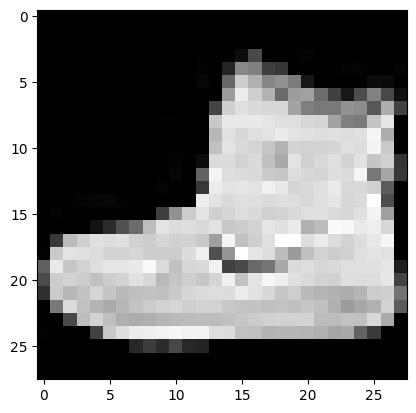

In [ ]:
plt.imshow(image.squeeze(),cmap = "gray")

In [ ]:
rand_image_tensor = torch.randn(size = (1,28,28)).to(device)
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
#Pass through the model
model_2(rand_image_tensor.unsqueeze(dim=0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 7.1 stepping through the `nn.Conv2d`

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {images.shape }")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
torch.manual_seed(42)
# Create a single Conv2d layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0
                       )

# pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(dim=0))
conv_output.shape

torch.Size([1, 10, 62, 62])

## 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image unsqueezed shape: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 4)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(0))
print(f"Test image through conv layer shape: {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image unsqueezed shape: torch.Size([1, 3, 64, 64])
Test image through conv layer shape: torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 15, 15])


In [ ]:
test_image

tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978,  1.0261,  1.1465,  ...,  1.2134,  0.9354, -0.0780],
         [-1.4647, -1.9571,  0.1017,  ..., -1

In [ ]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2))
print(f"\nRandom tensor\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a maxpool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass the random tensor through the maxpool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax Pool tensor\n {max_pool_tensor}")
print(f"Max Pool tensor shape: {max_pool_tensor.shape}")



Random tensor
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max Pool tensor
 tensor([[[[0.3367]]]])
Max Pool tensor shape: torch.Size([1, 1, 1, 1])


## 7.3 Setup a loss and optimizer for `model_2`

In [ ]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

## 7.4 Training and testing `model_2` using our training and test functions


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

  train_time_end_model_2 = timer()
  total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                              end = train_time_end_model_2,
                                              device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.59849 | Train acc:  78.23% 
Test loss: 0.39511 | Test acc:  85.77%

Train time on cuda: 16.479 seconds
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.36402 | Train acc:  86.85% 
Test loss: 0.35643 | Test acc:  86.83%

Train time on cuda: 33.906 seconds
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.32604 | Train acc:  88.27% 
Test loss: 0.31946 | Test acc:  88.65%

Train time on cuda: 48.363 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(model = model_2,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3194585144519806,
 'model_acc': 88.64816293929712}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_resluts= pd.DataFrame(data = [model_0_results, model_1_results, model_2_results])
compare_resluts

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.319459,88.648163


In [ ]:
# Add training time to resluts comparison
compare_resluts["training_time"] = [f"{total_train_time_model_0:.3f}",
                                     f"{total_train_time_model_1:.3f}",
                                     f"{total_train_time_model_2:.3f}"]
compare_resluts

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,34.133
1,FashionMNISTModelV1,0.685001,75.019968,36.724
2,FashionMNISTModelV2,0.319459,88.648163,48.363


Text(0, 0.5, 'Model')

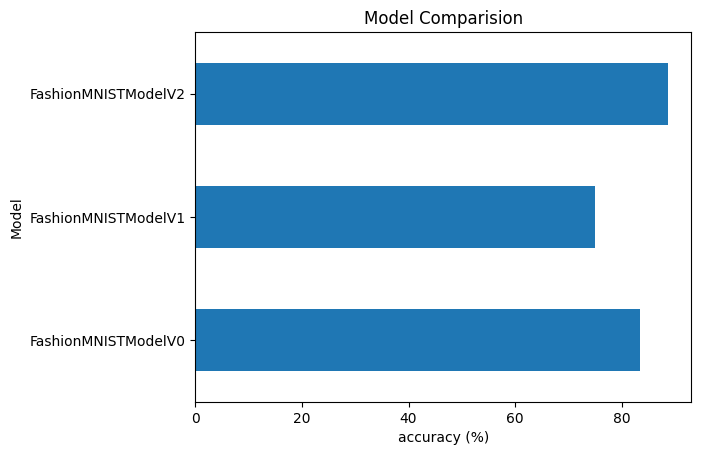

In [ ]:
# Visualize our model results
compare_resluts = compare_resluts.set_index("model_name")["model_acc"].plot(kind = "barh", title = "Model Comparision")
plt.xlabel("accuracy (%)")
plt.ylabel("Model")


## 9. Make and avaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)

            # Forward pass
            pred_logit = model(sample.unsqueeze(dim=0))

            # Get pred prob
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get Pred prob off the gpu
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_prob turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)


 # View the image size
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

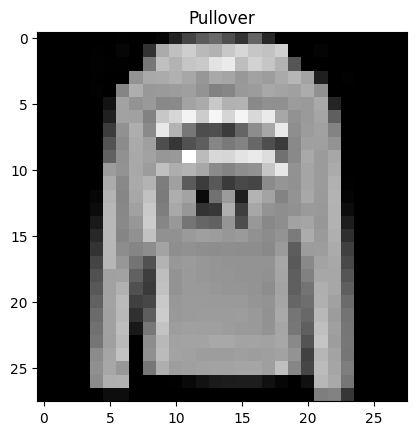

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View the first two prediction probabilities
pred_probs[:2]

tensor([[7.2566e-04, 5.0644e-05, 8.8171e-01, 2.2054e-03, 1.0425e-01, 2.8302e-05,
         1.0692e-02, 1.7297e-06, 3.3304e-04, 2.3448e-06],
        [1.2646e-02, 5.8216e-01, 1.7740e-04, 3.9791e-01, 7.9545e-04, 5.9637e-05,
         7.2455e-04, 4.4209e-04, 4.7804e-03, 2.9988e-04]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 3, 3, 5, 7, 1, 0, 4])

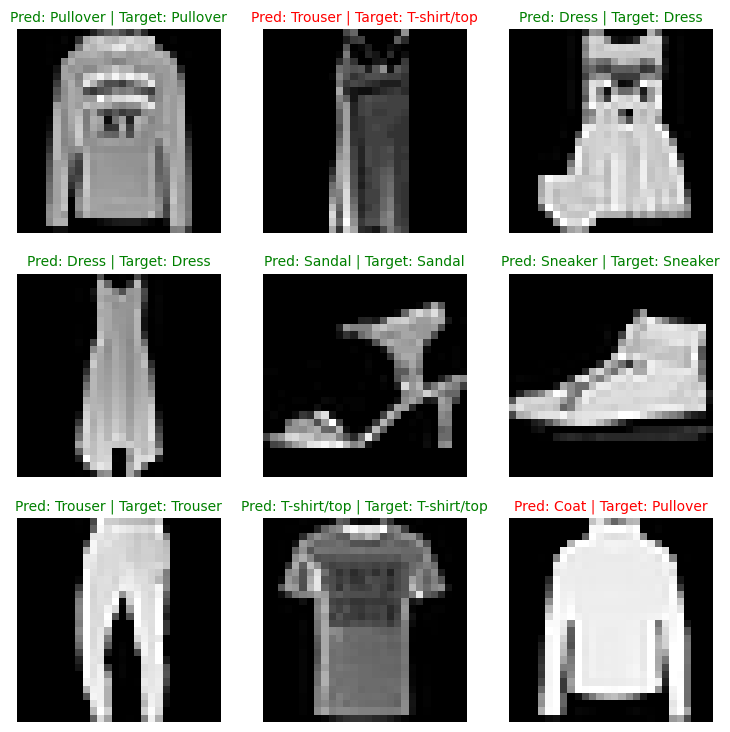

In [ ]:
# Plot predictions
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the the target image
    plt.imshow(sample.squeeze(), cmap = "gray")

    # Find the prediction (in text for, e.g "Sandal")
    pred_class = class_names[pred_classes[i]]

    # Find the target class (in text for, e.g "Sandal")
    target_class = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_class} | Target: {target_class}"

    # Check for correct or incorrect prediction
    if pred_class == target_class:
        plt.title(title_text, fontsize = 10, color = "g")
    else:
        plt.title(title_text, fontsize = 10, color = "r")

    plt.axis(False)


## 10. Makihg a confusion matrix for further prediction evaluation


1. Make prediction with our trained model
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making predictions...."):
        X, y = X.to(device), y.to(device)
        # Make predictions
        y_logit = model_2(X)

        # Turn prediction from logits -> predcition probabilities
        y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim=1)

        # Append prediction to list
        y_preds.append(y_pred.cpu())

# Concatenate list of predictins into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions....:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 8])

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
# See if required packeges are installed and if not, install them....
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1
mlxtend version: 0.23.1


In [ ]:
import mlxtend

In [ ]:
mlxtend.__version__


'0.23.1'

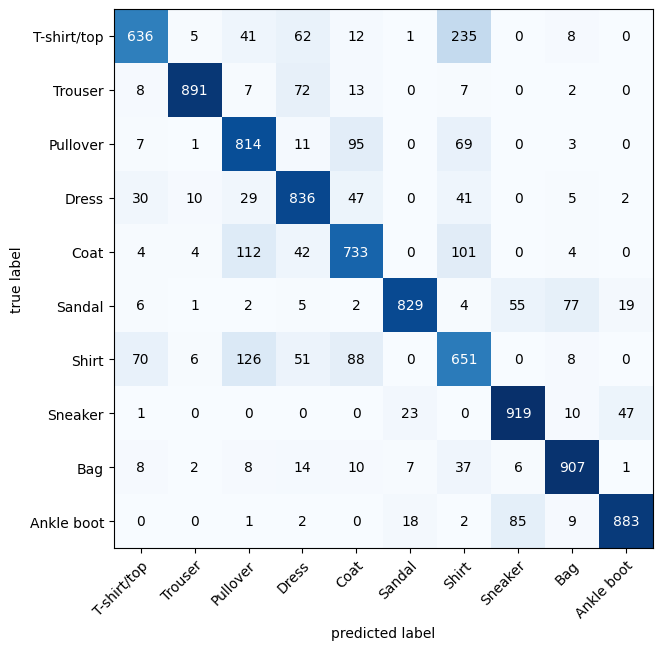

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Steup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task ="multiclass",num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize = (10,7)
                                )

##11. Save and load the best performing model

In [ ]:
from pathlib import PurePath
# Create a model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "03_PyTorch_CV._model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_PyTorch_CV._model_2.pth


In [ ]:
image_shape = [1,28,28]

In [ ]:
# Create a new instance
torch.manual_seed(42)
model_2_loaded = FashionMNISTModelV2(input_shape = 1,
                                      hidden_units = 10,
                                      output_shape = len(class_names))

# Load in the save state_dict()
model_2_loaded.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Put model on target device
model_2_loaded.to(device)

<ipython-input-85-680fef436854>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2_loaded.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3194585144519806,
 'model_acc': 88.64816293929712}

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

model_2_loaded_results = eval_model(
    model = model_2_loaded,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
model_2_loaded_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3194585144519806,
 'model_acc': 88.64816293929712}

In [ ]:
# Check id model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(model_2_loaded_results["model_loss"]),
              atol = 1e-08)

tensor(True)